# Text vectorization 

The current version performs the transformation of a text field (N x 1) -> (N x D) where (N X D) is a binary matrix of n-grams created after the input text field is processed.   

In [39]:
import csv
import pandas as pd

datafile = '/Users/elenalabzina/Documents/GitHub/DeconfounderAnalysis/data/death-penalty-cases.csv'
csv_file = open(datafile, mode='r')
csv_reader = csv.DictReader(csv_file)
data = pd.read_csv(datafile, encoding='utf-8')

text = pd.DataFrame(data[['snippet']])

text[0:5]

,snippet
0,N.J. 501 (1965)\n213 A.2d 20\nIN RE WAIVER OF ...
1,"whether the death penalty is, per se, unconsti..."
2,#39;s contention that the assessment of the de...
3,.3d 673 (2009)\n2009-NMSC-053\nIN THE MATTER O...
4,assume the district attorney orally waived the...


(The snippet field from the deathpenalty dataset is used purely as a starting example. Feel free to replace it with other datasource. )

## Initial cleaning: Cleansing, stemming and removal of the stopwords. 

In [40]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from string import ascii_lowercase
from nltk import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

stemmer = SnowballStemmer("english", ignore_stopwords=True)
tokenizer = RegexpTokenizer(r'[a-z]+')

##setting up and extending stopwords
stop = stopwords.words('english')
stop.extend(['nevertheless','would','nether''the','in','may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','quot','across','among','beside','however','yet','within']+list(ascii_lowercase))

#also we add 'death' and 'penalty' since they are very frequent 

stop.extend(['death','penalty'])

First, we are transforming our text field into tokens. For example, "I am eating pizza" => ['eat','pizza'].

In [43]:
tokens = []

for statement in text['snippet']:
    words = tokenizer.tokenize(statement.lower())
    #print(words)
    words_clean = []
    for word in words:
        if word in stop: 
            continue
        words_clean.append(stemmer.stem(word))
    tokens.append(words_clean)    

tokens[0:1]

[['waiver',
  'suprem',
  'court',
  'new',
  'jersey',
  'septemb',
  'hellip',
  'counti',
  'court',
  'judg',
  'waiver',
  'suprem',
  'court',
  'concern',
  'excess',
  'hellip',
  'case',
  'prosecutor',
  'seek',
  'cogniz',
  'fact',
  'situat',
  'hellip',
  'although',
  'prosecutor',
  'right',
  'waiv',
  'inform',
  'juri',
  'juri',
  'hellip',
  'assum',
  'prosecutor',
  'return',
  'ask']]

## Creating n-grams

Now we make n-grams. n is set to 3 but feel free to modify it. Before getting the final X, we need to count the occurancy of n-grams to evaluate the distribution and make sense of the data. 

In [72]:
my_ngrams=[]
n=3

for token_group in tokens:
    ngram = list(ngrams(token_group,n))
    my_ngrams.append(ngram)
    
#my_ngrams[0:2]

/Users/elenalabzina/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


In [73]:
#my_ngrams[0:2]

In [74]:
ngrams_dict=dict()
ngrams_counter=dict()
index = -1
max_occ=1
total = 0

for token_group in my_ngrams:
    for token in token_group:
        total = total + 1
        my_key = tuple(token)
        if my_key in ngrams_dict:
            ngrams_counter[my_key] = ngrams_counter[my_key]+1
            if (max_occ < ngrams_counter[my_key]): max_occ=ngrams_counter[my_key]
            continue
        index = index + 1
        ngrams_dict[my_key]=index
        ngrams_counter[my_key] = 1

### Filtering the distribution of the n-grams 

In [75]:
index, max_occ  



(364563, 2700)

Let's check the usual quantiles. 

In [77]:
import operator

ngrams_counter_sorted = sorted(ngrams_counter.items(), key=operator.itemgetter(1))
print(ngrams_counter_sorted[(int)(index*0.05)])
print(ngrams_counter_sorted[(int)(index*0.95)])

(('anoth', 'determin', 'whether'), 1)
(('base', 'record', 'us'), 3)


The data is very screwed. Let's have a look at some histograms: 

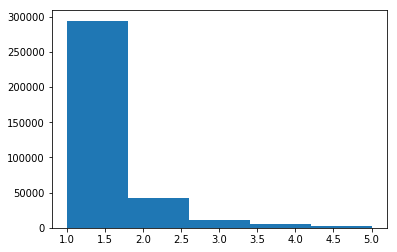

In [79]:
import matplotlib.pyplot as plt

plt.hist(ngrams_counter.values(),bins=5,range=(1,5))
plt.show()

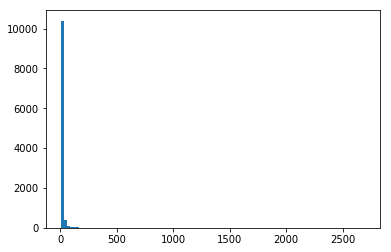

In [80]:
plt.hist(ngrams_counter.values(),bins=100,range=(5,max_occ))
plt.show()

What is the most frequent n-gram? 

In [100]:
mx=max(ngrams_counter.values())
print(mx)
print(total)

def return_all_val_from_dict(d,v): 
    l =list()
    for x, y in d.items():    
        if y == v: l.append(x)
    return l   

def count_in_dict(d,n):
    for x, y in d.items():    
        if y == v: return  

return_all_val_from_dict(ngrams_counter,mx)
# total

2700
581241


[('antiterror', 'effect', 'act')]

The chance for an n-gram to occur: $P(gram) = \frac{count(gram)}{total} = \frac{count(gram)}{581241}$. 

3-grams in our sample range in this respect: 
from $\frac{1}{total}$ to $\frac{mx}{total}$ = 1.7204567468571557e-06 to 0.00464523321651432

Let's pick only those with the chance of occurence of at least $0.0001$ or $ count(n-gram)>= 0.0001*total$  

This is (a bit) artibtrary but we need to pick some number to cut the tail off.   

In [86]:
cutoff = 0.00001*total
cutoff

5.812410000000001

In [85]:
ngrams_orderpos = list()

for key in ngrams_counter.keys():
    if ngrams_counter[key]<cutoff: continue
    ngrams_orderpos.append(key)
    
len(ngrams_orderpos)

8133

### Creating the final matrix

Hence, we decreased the number of variables from 364563 to 8133 by excluding the least frequent ones. Now we need to do the last step: to construct the binary matrix D:

In [89]:
import numpy as np

D = np.zeros(shape=(len(my_ngrams),len(ngrams_orderpos)))

index=-1

for index in range(0,len(my_ngrams)):
    for token in token_group:
        if token not in ngrams_orderpos: continue
        D[index, ngrams_orderpos.index(token)]=1

In [91]:
D.shape

(32567, 8133)

In [98]:
np.sum(D), len(my_ngrams)*len(ngrams_orderpos), len(my_ngrams)*len(ngrams_orderpos)/np.sum(D)

(97701.0, 264867411, 2711.0)

The data is still very sparse. 

## Occurancies instead of binary values:

In [ ]:
D = np.zeros(shape=(len(my_ngrams),len(ngrams_orderpos)))

index=-1

for index in range(0,len(my_ngrams)):
    for token in token_group:
        if token not in ngrams_orderpos: continue
        D[index, ngrams_orderpos.index(token)]=